In [1]:
%load_ext autoreload
%autoreload 2
import data
import model as m
import util
import os
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import itertools
import gc

In [2]:
#hyperparam
batch_size = 16 #64 -> 32
num_epochs = 32
device = "cuda:0" if torch.cuda.is_available() else "cpu"
learning_rate = 0.0001
reg_lambda = 0.0001

In [2]:
def dir_to_img_tensor(*paths):
    #return batch_size x channel x width x height
    layers_in_station = {}
    for path in paths:
        if not path.endswith('/'):
            path += '/'
        files = os.listdir(path)
        for file in files:
            file = path+file
            expression = r"station_(?P<label>\w+)_(?P<station_id>\d+)_(?P<zoom>\d+)_(?P<mode>\w+).png"
            regex = re.compile(expression)
            label,station_id,zoom,mode = regex.findall(file)[0]
            
            if label=="true":
                label = 1.
            elif label=="false":
                label = 0.
            
            img = cv2.imread(file)
            #img = np.transpose(img, (2,0,1))

            if not (station_id, zoom) in layers_in_station.keys():
                station_data = {'X':[img],'y':label}
                layers_in_station[(station_id, zoom)] = station_data
            else:
                layers_in_station[(station_id, zoom)]['X'].append(img) #image file은 특정 순서대로 저장됨

    X = np.array([np.concatenate(station_info['X'],axis=2) for station_info in layers_in_station.values()])
    y = np.array([station_info['y'] for station_info in layers_in_station.values()]).reshape([-1,1])

    return X, y

In [14]:
qpath = "../acquisition/data/crop_map/"
qfiles = os.listdir("../acquisition/data/crop_map/")

In [26]:
dic = set([])
for file in qfiles:
    file = file
    expression = r"station_(?P<label>\w+)_(?P<station_id>\d+)_(?P<zoom>\d+)_(?P<mode>\w+).png"
    regex = re.compile(expression)
    label,station_id,zoom,mode = regex.findall(file)[0]
    dic.add(station_id)

In [2]:
metadata = pd.read_csv("../acquisition/data/metadata.csv")
metadata['station_ID']

0         102
1         103
2         104
3         105
4         106
        ...  
6676    14023
6677    14024
6678    14025
6679    14026
6680    14027
Name: station_ID, Length: 6681, dtype: int64

In [3]:
zoom = [6,7,8]
mode = [4,9]
list(itertools.product(zoom, mode))

[(6, 4), (6, 9), (7, 4), (7, 9), (8, 4), (8, 9)]

In [4]:
path = "../acquisition/data/crop_map/"
def meta_to_img_tensor(path, station_id_lst, zooms=[6,7,8], modes=[4,9]):
    if not path.endswith('/'):
            path += '/'
    layers_in_station = {}
    #iters = itertools.product(zooms, modes)
    for station_id in tqdm(station_id_lst):
        for zoom, mode in itertools.product(zooms, modes):
            label, label_in_file = None, None
            if station_id < 10000:
                label = 1.
                label_in_file = "true"
            else:
                label = 0.
                label_in_file = "false"
            file = path + f"station_{label_in_file}_{station_id}_{zoom}_{mode}.png"
            img = cv2.imread(file)

            if not (station_id, zoom) in layers_in_station.keys():
                station_data = {'X':[img],'y':label}
                layers_in_station[(station_id, zoom)] = station_data
            else:
                layers_in_station[(station_id, zoom)]['X'].append(img)

    X = np.array([np.concatenate(station_info['X'],axis=2) for station_info in layers_in_station.values()])
    y = np.array([station_info['y'] for station_info in layers_in_station.values()]).reshape([-1,1])

    return X, y

In [25]:
station = metadata['station_ID']
partition_size = 150
partition = np.arange((station.shape[0]//partition_size)+2) * partition_size
partition_poll = zip(partition[:-1], partition[1:])

In [33]:
partition.shape, len(list(zip(partition[:-1], partition[1:])))

((46,), 45)

In [27]:
for idx, (s, e) in enumerate(partition_poll, 1):
    X, y = meta_to_img_tensor(path, metadata['station_ID'][:150])
    transform = data.compose_transform(X.shape[-1],img_size=(X.shape[1],X.shape[2]))
    dataset = data.MapDataset(X,y,transform)
    img_shape = dataset[0][0].shape
    data.save_dataset(dataset, f"pt/crop_{idx}.pt")
    gc.collect()

100%|██████████| 150/150 [00:30<00:00,  4.97it/s]


In [11]:
X, y = meta_to_img_tensor(path, metadata['station_ID'][:150])

100%|██████████| 150/150 [00:15<00:00,  9.92it/s]


In [12]:
#make torch dataset
transform = data.compose_transform(X.shape[-1],img_size=(X.shape[1],X.shape[2]))
dataset = data.MapDataset(X,y,transform)
img_shape = dataset[0][0].shape

In [59]:
X.shape, y.shape

((450, 448, 448, 6), (450, 1))

In [13]:
#save dataset
data.save_dataset(dataset, "crop_3.pt")

In [34]:
#load dataset
dataset1 = data.load_dataset("pt/crop_1.pt")
dataset2 = data.load_dataset("pt/crop_2.pt")
dataset3 = data.load_dataset("pt/crop_3.pt")
dataset4 = data.load_dataset("pt/crop_4.pt")
img_shape = dataset[0][0].shape

In [35]:
dataset = torch.utils.data.ConcatDataset([dataset1,dataset2,dataset3,dataset4])

In [39]:
path = "./pt/"
dataset = []
for file in os.listdir(path)[:15]:
    temp = data.load_dataset(path+file)
    dataset.append(temp)

In [40]:
tdataset = torch.utils.data.ConcatDataset(dataset)

In [41]:
len(tdataset)

6750

In [65]:
len(dataset2)

450

In [8]:
dataset[0][0].shape

torch.Size([6, 384, 384])

In [9]:
train_dataset, valid_dataset, test_dataset = util.split_data(dataset, 0.6,0.1,0.3)

In [15]:
#data loader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [11]:
#model
print(img_shape)
model = m.load_torch_hub("resnet18") #이 부분 수정하면 모델이 바껴요
model = m.fit_model_structure(model, img_shape[0], 1)

torch.Size([6, 384, 384])


Using cache found in C:\Users\netis/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\netis\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps

In [13]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_lambda)

Training: 100%|██████████| 17/17 [00:03<00:00,  4.41it/s]


[Epoch 1] loss: 0.465


100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Train accuracy = 0.794 // Valid accuracy = 0.744
Best model changed at epoch 1
ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 

Training: 100%|██████████| 17/17 [00:04<00:00,  4.06it/s]


[Epoch 2] loss: 0.441


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Train accuracy = 0.790 // Valid accuracy = 0.884
Best model changed at epoch 2
ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 

Training: 100%|██████████| 17/17 [00:03<00:00,  4.68it/s]


[Epoch 3] loss: 0.456


100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Train accuracy = 0.791 // Valid accuracy = 0.744


Training: 100%|██████████| 17/17 [00:03<00:00,  4.75it/s]


[Epoch 4] loss: 0.437


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Train accuracy = 0.781 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


[Epoch 5] loss: 0.302


100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


Train accuracy = 0.798 // Valid accuracy = 0.930
Best model changed at epoch 5
ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 

Training: 100%|██████████| 17/17 [00:03<00:00,  4.75it/s]


[Epoch 6] loss: 0.280


100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


Train accuracy = 0.809 // Valid accuracy = 0.814


Training: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]


[Epoch 7] loss: 0.270


100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


Train accuracy = 0.820 // Valid accuracy = 0.837


Training: 100%|██████████| 17/17 [00:03<00:00,  4.93it/s]


[Epoch 8] loss: 0.252


100%|██████████| 3/3 [00:00<00:00,  6.80it/s]


Train accuracy = 0.830 // Valid accuracy = 0.884


Training: 100%|██████████| 17/17 [00:03<00:00,  4.80it/s]


[Epoch 9] loss: 0.302


100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


Train accuracy = 0.834 // Valid accuracy = 0.744


Training: 100%|██████████| 17/17 [00:03<00:00,  4.82it/s]


[Epoch 10] loss: 0.358


100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


Train accuracy = 0.836 // Valid accuracy = 0.930


Training: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]


[Epoch 11] loss: 0.182


100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


Train accuracy = 0.842 // Valid accuracy = 0.930


Training: 100%|██████████| 17/17 [00:04<00:00,  4.09it/s]


[Epoch 12] loss: 0.172


100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


Train accuracy = 0.849 // Valid accuracy = 0.837


Training: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]


[Epoch 13] loss: 0.237


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


Train accuracy = 0.852 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.60it/s]


[Epoch 14] loss: 0.165


100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Train accuracy = 0.858 // Valid accuracy = 0.930


Training: 100%|██████████| 17/17 [00:03<00:00,  4.56it/s]


[Epoch 15] loss: 0.187


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Train accuracy = 0.862 // Valid accuracy = 0.837


Training: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]


[Epoch 16] loss: 0.121


100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Train accuracy = 0.867 // Valid accuracy = 0.884


Training: 100%|██████████| 17/17 [00:03<00:00,  4.70it/s]


[Epoch 17] loss: 0.058


100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


Train accuracy = 0.874 // Valid accuracy = 0.814


Training: 100%|██████████| 17/17 [00:03<00:00,  4.80it/s]


[Epoch 18] loss: 0.177


100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Train accuracy = 0.877 // Valid accuracy = 0.884


Training: 100%|██████████| 17/17 [00:03<00:00,  4.82it/s]


[Epoch 19] loss: 0.168


100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


Train accuracy = 0.879 // Valid accuracy = 0.930


Training: 100%|██████████| 17/17 [00:03<00:00,  4.64it/s]


[Epoch 20] loss: 0.155


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Train accuracy = 0.882 // Valid accuracy = 0.837


Training: 100%|██████████| 17/17 [00:03<00:00,  4.78it/s]


[Epoch 21] loss: 0.164


100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Train accuracy = 0.883 // Valid accuracy = 0.814


Training: 100%|██████████| 17/17 [00:03<00:00,  4.74it/s]


[Epoch 22] loss: 0.050


100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


Train accuracy = 0.888 // Valid accuracy = 0.930


Training: 100%|██████████| 17/17 [00:03<00:00,  4.78it/s]


[Epoch 23] loss: 0.017


100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Train accuracy = 0.893 // Valid accuracy = 0.814


Training: 100%|██████████| 17/17 [00:03<00:00,  4.73it/s]


[Epoch 24] loss: 0.014


100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


Train accuracy = 0.898 // Valid accuracy = 0.884


Training: 100%|██████████| 17/17 [00:03<00:00,  4.56it/s]


[Epoch 25] loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


Train accuracy = 0.902 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.81it/s]


[Epoch 26] loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Train accuracy = 0.905 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s]


[Epoch 27] loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


Train accuracy = 0.909 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.81it/s]


[Epoch 28] loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Train accuracy = 0.912 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.67it/s]


[Epoch 29] loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


Train accuracy = 0.915 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.69it/s]


[Epoch 30] loss: 0.000


100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


Train accuracy = 0.918 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


[Epoch 31] loss: 0.000


100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Train accuracy = 0.921 // Valid accuracy = 0.860


Training: 100%|██████████| 17/17 [00:03<00:00,  4.70it/s]


[Epoch 32] loss: 0.000


100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


Train accuracy = 0.923 // Valid accuracy = 0.860
Training finishied..
Best valid acc = 0.930 at epoch 5


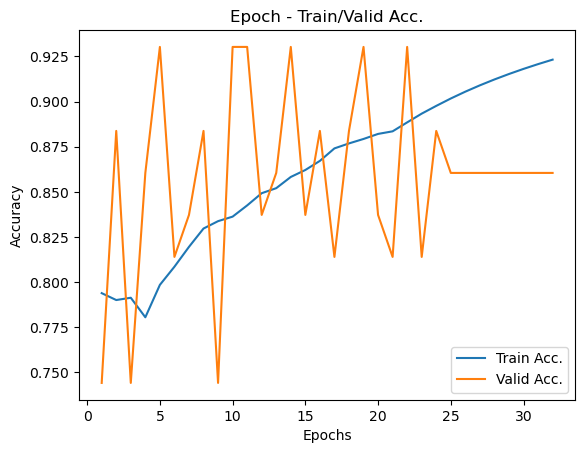

In [19]:
acc = m.train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, device, 1, "jibgagosibda") #모델 이름

In [20]:
state_dict = torch.load("best_model/jibgagosibda_best.pt")
for key, val in state_dict.items():
    print(key, val.shape)

conv1.0.weight torch.Size([64, 6, 1, 1])
conv1.1.weight torch.Size([64, 64, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.bn1.running_mean torch.Size([64])
layer1.1.bn1.running_var torch.Size([64])
layer1.1.bn1.num_batches_tracked torch.Size

In [ ]:
pred, correct = m.predict(model, test_loader, device)

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


In [ ]:
util.evaluation_metric(pred, correct)

{'confusion_matrix': array([[ 0, 11],
        [ 0, 34]], dtype=int64),
 'accuracy': 0.7555555555555555,
 'precision': 0.7555555555555555,
 'recall': 1.0,
 'f1_score': 0.8607594936708861}